# Modelisation joueur  


Imporations des dépendances

In [86]:
import torch
import torch.nn as nn
from torch.optim import AdamW
import math
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pickle



In [87]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Définissez l'appareil sur GPU
    print("GPU disponible :", torch.cuda.get_device_name(0))  # Affiche le nom du GPU
else:
    device = torch.device("cpu")  # Définissez l'appareil sur CPU
    print("GPU non disponible, utilisation du CPU.")

GPU disponible : NVIDIA RTX A4000



## Modele
  
### Bloc Transformer

In [88]:
class Attention(nn.Module):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim,):
        super(Attention, self).__init__()

        self.sqrt_hidden_dim = math.sqrt(hidden_dim)

        self.wq = nn.Parameter(torch.randn(hidden_dim, x_to_dim)).to(device)
        
        self.wk = nn.Parameter(torch.randn(hidden_dim, x_from_dim)).to(device)
        self.wv = nn.Parameter(torch.randn(x_to_dim, x_from_dim)).to(device)

    def forward(self, x_to, x_from):
        # x_to = [batch size, x_to_len, x_to_dim]
        # x_from = [batch size, x_from_len, x_from_dim]

        # les lettres dans les einsum :
        # b : le batch
        # x, y, z: la taille de l'ensemble (x_from ou x_to)
        # i,j : les éléments des vecteurs de x_from, x_to / les éléments de ces vecteurs une fois projetés (via Wq, Wk ou Wv)

        q = torch.einsum('ik,bxk->bxi',self.wq,x_to) # un tenseur de dimension (batch size, x_to_len, Dq)

        k = torch.einsum('ij,bxj->bxi',self.wk,x_from) # un tenseur de dimension (batch size, x_from_len, Dk=Dq)
        v = torch.einsum('ij,bxj->bxi',self.wv,x_from) # un tenseur de dimension (batch size, x_from_len, Dv)

        e = torch.softmax(torch.einsum('bxi,byi->bxy', q, k)/self.sqrt_hidden_dim, dim=1) # un tenseur de dimension (batch size, x_to_len, x_from_len)

        attention = torch.einsum('bxy,byi->bxi', e, v) # un tenseur de dimension (batch size, x_to_len, Dv)

        return attention

class MultiHeadAttention(nn.Module):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim, n_heads):
        super(MultiHeadAttention, self).__init__()
        heads_list = []
        for _ in range(n_heads):
            att = Attention(x_to_dim, x_from_dim, hidden_dim)
            heads_list.append(att)
        
        self.heads_list = heads_list
        self.output_projection = nn.Parameter(torch.randn(n_heads)).to(device)

    def forward(self, x_to, x_from):
        # x_to = [batch size, x_to_len, x_to_dim]
        # x_from = [batch size, x_from_len, x_from_dim]
        attention_list = []

        for head in self.heads_list:
            attention_list.append(head(x_to, x_from)) 

        concat = torch.stack(attention_list) # on obtient ainsi un tenseur représentant la concaténation des résultats des différentes "heads"

        result = torch.einsum('hbxi,h->bxi', concat, self.output_projection)

        return result

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, x_to_dim, hidden_dim, n_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.multhead = MultiHeadAttention(x_to_dim, x_to_dim, hidden_dim, n_heads)
    
    def forward(self, x_to):
        return self.multhead(x_to, x_to)

class LayerNorm(nn.Module):
    def __init__(self):
        super(LayerNorm, self).__init__()

    def forward(self, x):
        norm_x = torch.norm(x, dim=1).unsqueeze(1).expand_as(x)

        return x/norm_x

class FFN(nn.Sequential):
    def __init__(self, input_dim, dropout_rate=0.1, expansion_factor=2):
        super(FFN, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, input_dim*expansion_factor)
        self.dropout_layer = nn.Dropout(p = dropout_rate)
        self.output_layer = nn.Linear(input_dim*expansion_factor, input_dim)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = nn.LeakyReLU(negative_slope=0.1)(self.dropout_layer(x))
        x = self.output_layer(x)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, data_dim, hidden_dim, n_heads, dropout_rate=0.1):
        super(TransformerEncoderBlock, self).__init__()

        self.bloc_self_attention = MultiHeadSelfAttention(data_dim, hidden_dim, n_heads)

        self.bloc_normalization_1 = LayerNorm()

        self.bloc_FFN = FFN(data_dim, dropout_rate=dropout_rate)

        self.bloc_normalization_2 = LayerNorm()
        # It's useless to use 2 LayerNorm, cause they are the same. 
        # Yet, because it's my first transformer,
        # I will keep both of them for clarity in my mind


    def forward(self, x):
        # x = [batch size, x_len, hidden dim]
        identity = x
        x = self.bloc_self_attention(x)
        x = self.bloc_normalization_1(x+identity)

        identity = x
        x = self.bloc_FFN(x)
        x = self.bloc_normalization_2(x+identity)

        return x

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len, const = 10000):
        super(SinusoidalPositionalEncoding, self).__init__()

        self.pe = torch.zeros(max_len, hidden_dim).to(device)

        for i in range(max_len):
            for j in range(hidden_dim):
                if j%2==0:
                    self.pe[i, j] = math.sin(i/(const**(j/hidden_dim)))
                else:
                    self.pe[i, j] = math.cos(i/(const**((j-1)/hidden_dim)))

    def forward(self, x):
        # x = [batch size, len_x, dim_vect_de_x]
        dim_batch = x.size(0) # dimension du batch
        for k in range(dim_batch):
            x[k] += self.pe[:x[k].size(0),:] # on somme le tenseur PE sur chaque élément du batch
        return x

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len):
        super(LearnedPositionalEncoding, self).__init__()

        self.pe = nn.Parameter(torch.randn(max_len, hidden_dim)).to(device)


    def forward(self, x):
        dim_batch = x.size(0) # dimension du batch
        for k in range(dim_batch):
            x[k] += self.pe[:x[k].size(0),:] # on somme le tenseur PE sur chaque élément du batch
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, data_dim,  hidden_dim, n_heads, n_layers, dropout_rate=0.1, positional_encoding="sinusoidal", max_len=1000):
        super(TransformerEncoder, self).__init__()
        if positional_encoding == "sinusoidal":
            self.layer_positional_encoding = SinusoidalPositionalEncoding(data_dim, max_len)
        else:
            self.layer_positional_encoding = LearnedPositionalEncoding(data_dim, max_len)
        
        self.bloc_transformer_list = nn.ModuleList([TransformerEncoderBlock(data_dim, hidden_dim, n_heads, dropout_rate) for i in range(n_layers)])

    def forward(self, x, mask):
        x = self.layer_positional_encoding(x)

        for transformer_block in self.bloc_transformer_list:
            x = transformer_block(x) * mask

        return x
    


### Modele global

In [89]:
class MLP(nn.Module):
    def __init__(self, layers_sizes):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(in_features=layers_sizes[i], out_features=layers_sizes[i+1]) for i in range(len(layers_sizes)-1)])

    def forward(self, x):
        for layer in self.layers:
            x = nn.LeakyReLU()(layer(x))
        return x


class PlayerModel(nn.Module):
    def __init__(self, layer_size_embedding, layer_size_output, hidden_dim_transformer, n_heads_transformer, n_layers_transformer, max_len_for_encoding):
        super(PlayerModel, self).__init__()

        self.dim_embedding = layer_size_embedding[-1]

        self.embedding_layer = MLP(layers_sizes=layer_size_embedding)

        self.transformer_encoder = TransformerEncoder(data_dim = self.dim_embedding, hidden_dim = hidden_dim_transformer, n_heads = n_heads_transformer, n_layers = n_layers_transformer, positional_encoding="learned", max_len=max_len_for_encoding)

        self.decoder = MLP(layers_sizes=layer_size_output)

    def forward(self, x):

        mask = self.make_mask(x, self.dim_embedding)

        x = self.embedding_layer(x)
        x = self.transformer_encoder.forward(x, mask)[:,0,:]
        x = self.decoder(x)

        return x

    def make_mask(self, x, dim_embedding):
        
        return torch.ones_like(x)[:,:,:dim_embedding].to(device)


## Entrainement

### Fonctions annexes

Datasets : 

In [90]:
with open("./data_transformer", "rb") as temp:
    data = pickle.load(temp)

maxlen = 0
for sequence, reponse in data:
    if len(sequence)>maxlen:
        maxlen = len(sequence)

print("maxlen = ", maxlen)

for sequence, response in data:
    for _ in range(len(sequence), maxlen):
        sequence.append([0., 0., 0., 0., 0., 0., 0., 0., 0.])

# print(data[53])
# il y a 55924 éléments
class PlayerDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_data, output_data = self.data[idx]
        return torch.tensor(input_data), torch.tensor(output_data)


training_data = PlayerDataset(data[:50000])
test_data = PlayerDataset(data[50000:55924])

maxlen =  42


Fonction d'evaluation :

In [91]:
def success_rate_2(model,test_data):
    loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
    with torch.no_grad():
        bonne_identification = 0

        for batch in loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            
            y_pred = model(x_batch).squeeze()

            for ind in range(len(y_pred)):
                if y_batch[ind][torch.argmax(y_pred[ind])] >0.5:
                    bonne_identification += 1
    return(bonne_identification/len(test_data))

In [92]:
def action_rate(action):
    loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
    with torch.no_grad():
        bonne_identification = 0

        for _, y_batch in loader:
            
            for ind in range(len(y_batch)):
                if y_batch[ind][action] >0.5:
                    bonne_identification += 1
    
    return(bonne_identification/len(test_data))

Fonction d'entrainement

In [93]:

def trainer(train_data, test_data, model, loss_fn,epoch=10,batch_size=64,rate=1e-4):

    optimizer = torch.optim.Adam(model.parameters(), lr=rate)

    loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

    loss_list = []
    acc_list = []
    

    len_batch = len(loader)

    for t in range(epoch):

        loss_batch = 0.0

        for batch in tqdm(loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)

            if isinstance(loss_fn, torch.nn.MSELoss):
                y_batch = y_batch.float()
            loss = loss_fn(y_pred, y_batch)
        
            loss.backward()
            optimizer.step()

            loss_batch += float(loss.detach())

        loss_list.append(loss_batch/len_batch)
        acc = success_rate_2(model, test_data)
        acc_list.append(acc)

        print('epoch ', t, ' : accuracy=', acc, ' loss=',loss_list[-1])
    
    return acc_list, loss_list




### Entrainement du modele

In [94]:
# modele de base : 196K parametres
# modele suivant : 

dim_data_sequence = 9
dim_output = 3

dim_embedding = 6

modelisation_joueur = PlayerModel(layer_size_embedding=[dim_data_sequence, 32, dim_embedding],
                                  layer_size_output= [dim_embedding, 32, 16, dim_output],
                                  hidden_dim_transformer= 2*dim_embedding,
                                  n_heads_transformer= 6,
                                  n_layers_transformer= 6, 
                                  max_len_for_encoding = maxlen
                                  ).to(device)

In [95]:
print(success_rate_2(modelisation_joueur, test_data))
print(action_rate(action = 0))

0.1850101282916948
0.6218771100607697


In [100]:
acc_list, loss_list = trainer(training_data, test_data, modelisation_joueur, loss_fn = nn.CrossEntropyLoss(), epoch=60, batch_size=64)


100%|██████████| 782/782 [00:17<00:00, 44.68it/s]


epoch  0  : accuracy= 0.6797771775827144  loss= 0.7410198120433656


 42%|████▏     | 330/782 [00:07<00:09, 45.46it/s]

In [ ]:
print(acc_list)
print([float(loss) for loss in loss_list])


[0.6218771100607697, 0.6782579338284943, 0.6900742741390952, 0.6956448345712356, 0.7077987846049967, 0.7091492234976368, 0.7157326130992573, 0.7182646860229575, 0.7192775151924375, 0.7140445644834571, 0.7218095881161377, 0.7196151249155975, 0.7231600270087779, 0.7228224172856178, 0.7300810263335584, 0.7288993923024983, 0.7302498311951384, 0.7336259284267387, 0.7305874409182984, 0.7297434166103984, 0.7332883187035787, 0.7326130992572586, 0.7361580013504389, 0.7385212694125591, 0.7341323430114788, 0.7344699527346388, 0.7348075624577988, 0.7351451721809588, 0.7371708305199189, 0.7405469277515192]
[1.107830286026001, 1.1025035381317139, 1.0991456508636475, 1.0988982915878296, 1.098934292793274, 1.0988465547561646, 1.0987926721572876, 1.098680853843689, 1.098591685295105, 1.0984355211257935, 1.0982177257537842, 1.0875097513198853, 1.0158283710479736, 0.9422054290771484, 0.9275959134101868, 0.9086920022964478, 0.9320452809333801, 0.8598958253860474, 0.8899478912353516, 0.9391869306564331, 0.

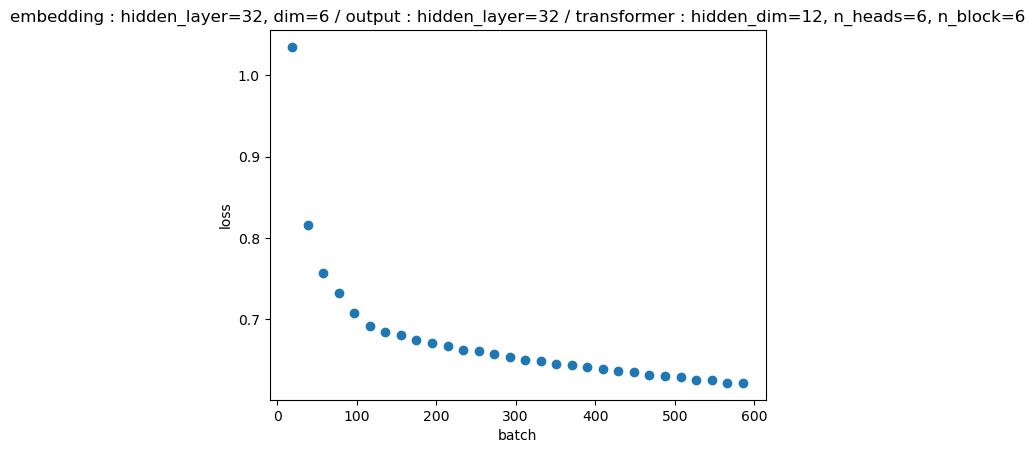

In [ ]:
plt.plot(loss_list, label = 'loss')

plt.xlabel('batch')
plt.ylabel('loss')
plt.title('embedding : hidden_layer=32, dim=6 / output : hidden_layer=32 / transformer : hidden_dim=12, n_heads=6, n_block=6')

plt.show()


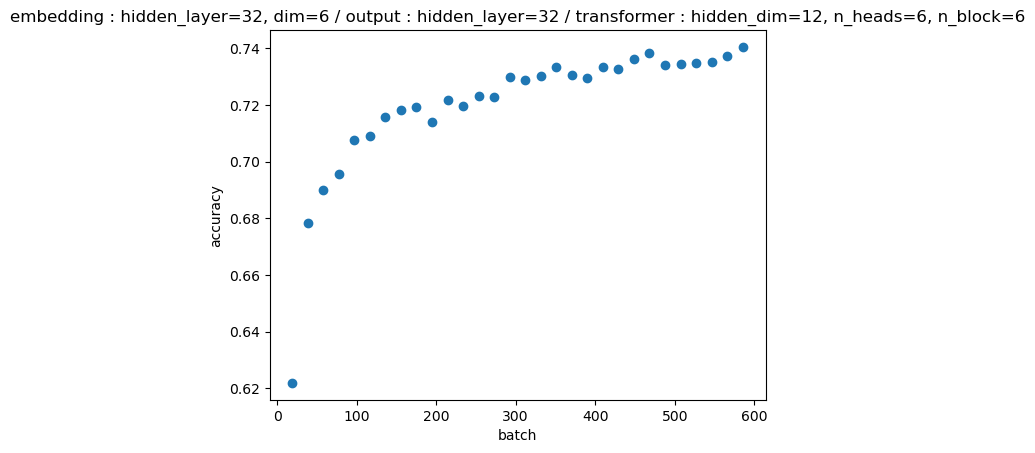

In [ ]:
plt.plot(acc_list, label = 'accuracy')

plt.xlabel('batch')
plt.ylabel('accuracy')
plt.title('embedding : hidden_layer=32, dim=6 / output : hidden_layer=32 / transformer : hidden_dim=12, n_heads=6, n_block=6')

plt.show()